In [3]:
# Source 
# https://dev.to/edgaras/face-recognition-with-facenet-ha8 

In [ ]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image, ImageDraw
import numpy as np
import mmcv, cv2
from torchvision import transforms
import os

# Initialize MTCNN and InceptionResnetV1
mtcnn = MTCNN(image_size=160, keep_all=True, device='cpu')
resnet = InceptionResnetV1(pretrained='vggface2').eval().to('cpu')

# Detect faces and draw bounding boxes
def detect_faces(frames):
    total_faces_detected = 0
    frames_tracked = []
    face_list = []  # List of cropped faces for embedding extraction

    for i, frame in enumerate(frames):
        print(f'\rTracking frame: {i + 1}', end='')

        # Detect faces
        frame_np = np.array(frame)

        try:
            boxes, probs = mtcnn.detect(frame_np)
        except Exception as e:
            print(f"\nError on frame {i}: {e}")
            boxes = None

        # Track how many bounding boxes
        count = 0  # Reset count for each frame

        # Draw boxes
        frame_draw = frame.copy()  # Make a copy of the frame to draw on
        draw = ImageDraw.Draw(frame_draw)

        if boxes is not None and len(boxes) > 0:
            count = len(boxes)  # Each box corresponds to detected face
            total_faces_detected += count  # Add the count of detected faces to the total count

            # Draw bounding boxes on the frame (ensure this is a PIL image)
            for box in boxes:
                draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

            # Add to frame list (resize for display or other purposes)
            frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))

            # Crop faces based on boxes > store in face_list
            faces = mtcnn(frame)  # MTCNN returns cropped faces as a list of PIL images
            face_list.extend(faces)

        else:
            print("No boxes created")

    print(f"\nTotal number of faces detected across all frames: {total_faces_detected}")
    return frames_tracked, face_list

def save_frames_as_images(frames, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for i, frame in enumerate(frames):
        # Save each frame as a PNG file
        frame_filename = os.path.join(output_folder, f"Frame_{i+1}.png")
        frame.save(frame_filename)
        print(f"Saved: {frame_filename}")

# Example video frames (replace with actual frames from your video)
video = mmcv.VideoReader('video/premierleaguevideo.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]  # Convert frames to PIL images

# Step 1: Detect faces and get cropped faces for embedding extraction
frames_tracked, faces = detect_faces(frames)

# Step 2: Save the frames to images
if frames_tracked:
    output_folder = 'processed_frames'  # Folder to save frames as images
    save_frames_as_images(frames_tracked, output_folder)
else:
    print("No frames processed.")

print('\nDone')

c:\Users\user\Documents\Projects\Internship\faceNet\faceNet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tracking frame: 59No boxes created
Tracking frame: 60No boxes created
Tracking frame: 61No boxes created
Tracking frame: 62No boxes created
Tracking frame: 63No boxes created
Tracking frame: 64No boxes created
Tracking frame: 65No boxes created
Tracking frame: 66No boxes created
Tracking frame: 67No boxes created
Tracking frame: 68No boxes created
Tracking frame: 69No boxes created
Tracking frame: 70No boxes created
Tracking frame: 71No boxes created
Tracking frame: 72No boxes created
Tracking frame: 73No boxes created
Tracking frame: 74No boxes created
Tracking frame: 75No boxes created
Tracking frame: 76No boxes created
Tracking frame: 78No boxes created
Tracking frame: 79No boxes created
Tracking frame: 80No boxes created
Tracking frame: 81No boxes created
Tracking frame: 82No boxes created
Tracking frame: 84No boxes created
Tracking frame: 85No boxes created
Tracking frame: 86No boxes created
Tracking frame: 87No boxes created
Tracking frame: 88No boxes created
Tracking frame: 89No

In [5]:
# Load frames from processed frames folder
def load_processed_frames(folder_path):
    
    frames = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            frames.append(Image.open(image_path)) # Load as PIL Image
    print("Frames:", frames)
    return frames

frames_loaded = load_processed_frames('processed_frames')

Frames: [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F97ED4F0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F97EE1B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F97ED130>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F41F5083E0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F7A27E00>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F41F3AE570>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F41DF127E0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F9805190>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F97D56D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F983A7B0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F983A360>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=640x360 at 0x1F5F983A5A0>, <PIL.PngImagePlugin.PngImageFil

In [9]:
# Extract embeddings from processed frame images
def extract_embeddings_from_frames(frames):

    embeddings_list = [] # Store embeddings for all faces detected

    # Loop through each frame
    for frame in frames:
        # Detect faces in the current frame
        faces = mtcnn(frame) # MTCNN returns cropped faces as list of PIL Images

        if faces is not None:
            # Extract embeddings for each face
            embeddings = resnet(faces).detach().cpu().numpy() # Extract embeddings from faces

            embeddings_list.extend(embeddings) # Append embeddings to list

            np.save('embeddings.npy', embeddings)

    return embeddings_list # Return the list of embeddings for all faces

embeddings = extract_embeddings_from_frames(frames_loaded)
print(f"Extracted embeddings for {len(embeddings)} faces.")

Extracted embeddings for 1132 faces.


In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load embeddings
loaded_embeddings = np.load('embeddings.npy')
embeddings_array = np.array(loaded_embeddings)

# Apply DBSCAN clustering to embeddings
dbscan = DBSCAN(eps=0.8, min_samples=3, metric='euclidean')
labels = dbscan.fit_predict(embeddings)

# Labels indicate which embeddings belong to the same cluster
# -1 means outlier (a face that doesn't match any player)
print(f"Cluster labels: {labels}")

# Create player templates by averaging embeddings within each cluster
player_templates = {}
for i, label in enumerate(labels):
    if label != -1: # Ignore outliers
        if label not in player_templates:
            player_templates[label] = [embeddings[i]] # Start a new cluster for the player
        else:
            player_templates[label].append(embeddings[i]) # Append to existing cluster

for player_id, cluster_embeddings in player_templates.items():
    
    # Average the embeddings for the player
    player_template = np.mean(cluster_embeddings, axis=0)
    player_templates[player_id] = player_template
    print(f"Player {player_id} template: {player_template}")

# Convert templates to DataFrame
df = pd.DataFrame.from_dict(player_templates, orient='index')

# Save DataFrame to CSV
df.to_csv('player_templates.csv', header=False)

Cluster labels: [0 0 0 ... 0 0 0]
Player 0 template: [ 1.48074003e-02 -8.28731153e-03 -1.54799623e-02  2.70514283e-02
 -1.67951640e-02  4.47866553e-03 -2.70100646e-02 -7.28651974e-03
 -8.30348954e-03  3.64160463e-02  3.38889621e-02  7.10282708e-04
 -4.80439477e-02 -1.60184205e-02  2.47830227e-02 -1.16828838e-02
  1.09418128e-02  1.32810790e-02 -7.02025089e-03  4.29578358e-03
 -8.85822717e-03  2.78678387e-02  1.64676085e-02 -2.63934061e-02
 -5.61730899e-02 -2.50805146e-03  5.03502041e-03  2.01788507e-02
 -2.09414382e-02 -1.21400366e-02 -5.36068436e-03  3.71485502e-02
  2.25063115e-02  1.20842699e-02 -1.25246607e-02 -5.85984206e-03
  2.38946639e-02  7.52238836e-03  2.09923033e-02 -1.59836020e-02
  1.62151374e-03  7.99132162e-04  1.38303069e-02  2.65319482e-03
  1.48833571e-02 -2.12788917e-02  1.63310729e-02 -3.11071761e-02
 -8.23480822e-03  8.80288705e-03  1.12979375e-02  2.47081779e-02
  1.25883427e-02 -4.80388058e-03 -3.56708243e-02  3.55687272e-03
 -1.20997252e-02  2.79307645e-02  8.1

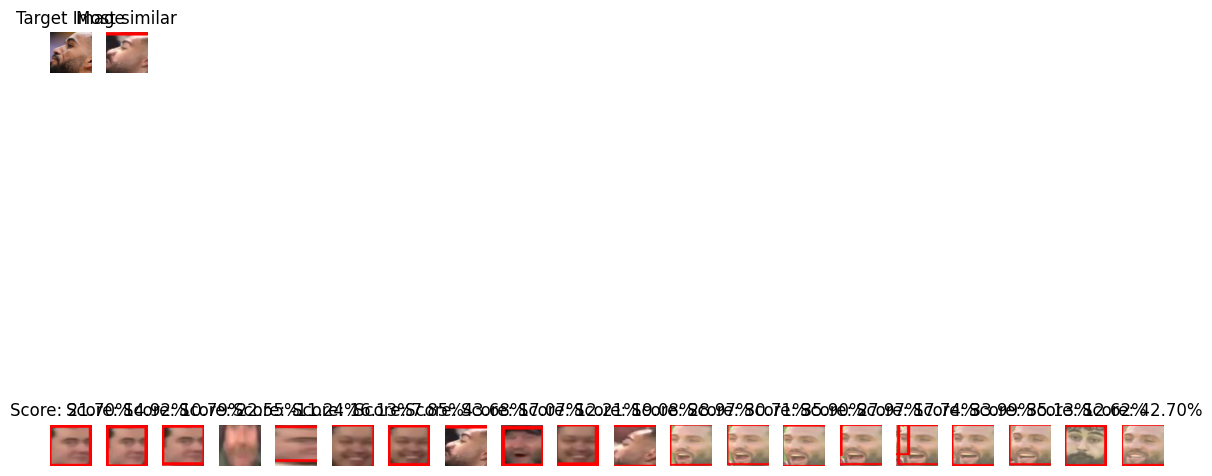

The most similar image is: C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_8.png
Similarity score: 43.68%


In [ ]:
import matplotlib.pyplot as plt
from io import BytesIO
import requests

def get_embedding_for_target(image_path):
    """Get embedding for a target image and return the embedding and face image."""
    try:
        # Check if the image path exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at: {image_path}")

        # Open the image
        image = Image.open(image_path).convert("RGB")

        # Detect faces using MTCNN
        faces, _ = mtcnn(image, return_prob=True)

        if faces is None or len(faces) == 0:
            print(f"No face detected in image: {image_path}")
            return None, None
        
        # Extract the embedding for the first face detected
        embedding = resnet(faces[0].unsqueeze(0)).detach().cpu().numpy()
        return embedding, faces[0]

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None

def tensor_to_image(tensor):
    """Convert a tensor to a valid image array."""
    image = tensor.permute(1, 2, 0).detach().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    image = (image * 255).astype('uint8')
    return image

def find_most_similar(target_image_path, player_image_paths):
    """Find the most similar player image to the target image."""
    
    # Get the embedding for the target image
    target_emb, target_face = get_embedding_for_target(target_image_path)
    if target_emb is None:
        raise ValueError("No face detected in the target image.")
    
    highest_similarity = float('-inf')
    most_similar_face = None
    most_similar_image_path = None

    player_faces = []
    similarities = []

    # Iterate through player image paths
    for player_image_path in player_image_paths:
        player_emb, player_face = get_embedding_for_target(player_image_path)
        if player_emb is None:
            similarities.append(None)
            player_faces.append(None)
            continue

        # Calculate similarity between the target and player embeddings
        similarity = torch.nn.functional.cosine_similarity(torch.tensor(target_emb), torch.tensor(player_emb)).item()
        similarities.append(similarity)
        player_faces.append(player_face)

        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_face = player_face
            most_similar_image_path = player_image_path
    
    # Visualization of the target face and most similar player face
    plt.figure(figsize=(12, 8))

    # Display target image
    plt.subplot(2, len(player_image_paths) + 1, 1)
    plt.imshow(tensor_to_image(target_face))
    plt.title("Target Image")
    plt.axis("off")

    # Display most similar player image
    if most_similar_face is not None:
        plt.subplot(2, len(player_image_paths) + 1, 2)
        plt.imshow(tensor_to_image(most_similar_face))
        plt.title("Most similar")
        plt.axis("off")

    # Display all player images with similarity scores
    for idx, (player_face, similarity) in enumerate(zip(player_faces, similarities)):
        plt.subplot(2, len(player_image_paths) + 1, idx + len(player_image_paths) + 2)
        if player_face is not None:
            plt.imshow(tensor_to_image(player_face))
            plt.title(f"Score: {similarity * 100:.2f}%")
        else:
            plt.title("No face")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    if most_similar_image_path is None:
        raise ValueError("No faces detected in the player images.")
    
    return most_similar_image_path, highest_similarity

# Define the target image and player image paths
image_url_target = "C:/Users/user/Documents/Projects/Internship/faceNet/target_images/matheus_cunha2.jpg"
player_image_urls = ["C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_1.png", 
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_2.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_3.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_4.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_5.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_6.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_7.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_8.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_9.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_10.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_11.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_12.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_13.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_14.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_15.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_16.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_17.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_18.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_19.png",
                     "C:/Users/user/Documents/Projects/Internship/faceNet/processed_frames/Frame_20.png"]  # Add more player image paths here

# Find the most similar image
most_similar_image, similarity_score = find_most_similar(image_url_target, player_image_urls)
print(f"The most similar image is: {most_similar_image}")
print(f"Similarity score: {similarity_score * 100:.2f}%")



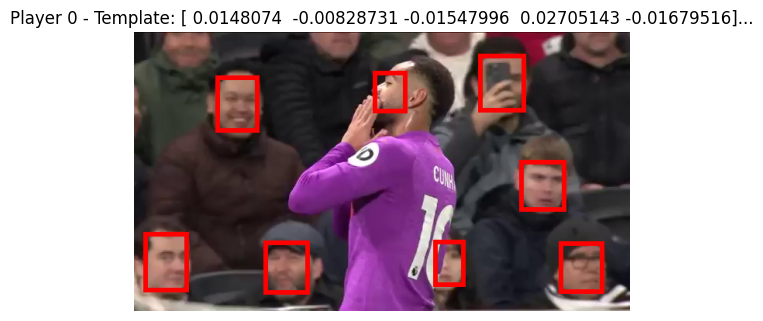

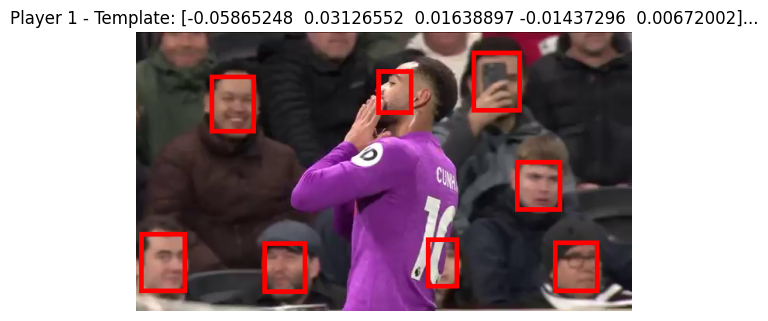

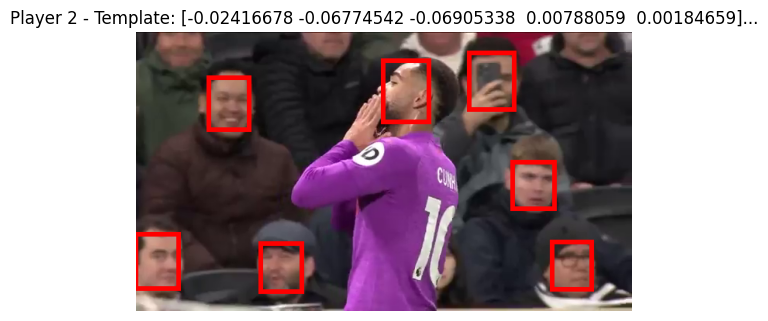

In [ ]:
# import matplotlib.pyplot as plt

# Load embeddings CSV
loaded_templates_df = pd.read_csv('player_templates.csv', header=None, index_col=0)

# PIL Images
image_folder = 'processed_frames'
image_files = [f"Frame_{i+1}.png" for i in range(len(loaded_templates_df))]

# Display faces and corresponding embeddings
for i, (index, row) in enumerate(loaded_templates_df.iterrows()):
    # Load image corresponding to the current player template (embedding)
    face_image_path = f"{image_folder}/{image_files[i]}"
    face_image = Image.open(face_image_path)

    # Show the image
    plt.imshow(face_image)
    plt.title(f"Player {index} - Template: {row.values[:5]}...") # Show first 5 elements of the embedding preview
    plt.axis('off')
    plt.show()


In [ ]:
# # Extract Facial Embeddings using detected faces
# def extract_embeddings(faces):
#     # Convert faces to tensors
#     faces_tensor = torch.stack([transforms.ToTensor()(face).unsqueeze(0) for face in faces])  # Convert PIL images to tensor

#     # Extract embeddings using InceptionResnetV1
#     embeddings = resnet(faces_tensor).detach().cpu().numpy()  # Extract embeddings from faces
#     print("Embeddings extracted for {} faces".format(len(faces)))  # Print number of faces processed
#     return embeddings


# # Main Process
# # Sample video frames (replace with actual frames from your video)
# frames = [Image.open('frame_1.jpg'), Image.open('frame_2.jpg')]  # Replace with actual frames

# # Step 1: Detect faces and get cropped faces for embedding extraction
# frames_tracked, faces = detect_faces(frames)

# # Step 2: Extract embeddings from cropped faces
# embeddings = extract_embeddings(faces)  # Pass the cropped faces to extract_embeddings

# Sample video
# video = mmcv.VideoReader('video/premierleaguevideo.mp4')
# frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
# display.Video('video/premierleaguevideo.mp4', width=640)

# # Global counter to track total number of faces detected
# total_faces_detected = 0

# # Run video through MTCNN
# frames_tracked = []
# for i, frame in enumerate(frames):
#     # print('\rTracking frame: {}'.format(i + 1), end='')

#     # Detect faces
#     frame_np = np.array(frame)

#     try:
#         boxes, probs = mtcnn.detect(frame_np)
#     except Exception as e:
#         print(f"\nError on frame {i}: {e}")
#         boxes = None
    
#     # Track how many bounding boxes
#     count = 0 # Reset count for each frame

#     # Draw boxes
#     frame_draw = frame.copy()
#     draw = ImageDraw.Draw(frame_draw)

#     if boxes is not None and len(boxes) > 0:

#         # Count the number of boxes (faces) detected in frame
#         count = len(boxes) # Each box corresponds to detected face
#         total_faces_detected += count # Add the count of detected faces to the total count

#         # Draw bounding boxes on the frame
#         for box in boxes:
#             draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)

#         # Add to frame list 
#         frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
#     else:
#         print("No boxes created")

# # After processing all frames, print the total number of faces detected
# print(f"\nTotal number of faces detected across all frames: {total_faces_detected}")
# print('\nDone')

# Save video
# dim = frames_tracked[0].size
# fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
# video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
# for frame in frames_tracked:
#     video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
#     print("Video saved")
# else:
#     print("No video saved")
# video_tracked.release()

# Dictionary to store player templates (embedding vectors)
# player_templates = {}

# def create_player_template(player_id, face_embeddings):
#     # Create or update a player's template with the average of embeddings
#     if player_id not in player_templates:
#         # Initialise player template with the first embedding
#         player_templates[player_id] = np.array(face_embeddings)
#     else:
#         # Update the player template by averaging the new embedding with the existing one
#         player_templates[player_id] = (player_templates[player_id] + np.array(face_embeddings)) / 2
#     print(f"Updated template for {player_id}")

# def process_video_for_templates(video_path):
#     # Process video and create player templates from the detected faces

#     # Open video
#     cap = cv2.VideoCapture(video_path)
#     # Check if video opened successfully
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return
    
#     # Read frames one by one
#     while cap.isOpened():
#         ret, frame = cap.read()

#         if not ret:
#             break # End the video

#         # Convert frame from BGR (OpenCV) to RGB (PIL)
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         pil_image = Image.fromarray(frame_rgb)

#         # Detect faces in the frame
#         boxes, probs = mtcnn.detect(pil_image)

#         if boxes is not None:
#             # Extract embeddings for each detected face
#             faces = mtcnn(pil_image)
#             faces = faces.to(device) # Move faces to the same device as the model
#             embeddings = resnet(faces).detach().cpu().numpy() # Convert to numpy array

#             for emb in embeddings:
#                 player_id = 'player_1'
#                 create_player_template(player_id, emb)

#     cap.release()
#     print("Done processing video.")

# # Example usage: Process video and create templates
# video_path = 'video/premierleaguevideo.mp4' 
# process_video_for_templates(video_path)

# # Print player templates created
# print("Player templates:", player_templates)